### Baseline calculator

* load waveforms
* calculate baseline from the signal-less regions. Done by calculation of Analog*D2, with D2 the baseline inhibit signal

In [1]:
import sys
sys.path.insert(0,'python/')
from DT5550_Waveform import *

import os, glob, json
import matplotlib.pyplot as plt
import numpy as np

In [5]:
filename = '../../data/20211215_132503/waveform_20211215_132503_0.raw'
#filename = '../../DT5550_DAQ/daq/ReadoutClient/waveform.raw'
indir = os.path.dirname(filename)
config_file = glob.glob(indir+'/config*.json')[0]

In [8]:
#
# open the datfile
#
print('Open datafile:',filename)
waves = DT5550_Waveform(file=filename)
#
# read a single event
#
waves.read_event()
waves.read_event()

#
# calculate the baseline
#
baseline = waves.analog[:,:]*waves.digital[2,:,:]
# for detector 7 the digital output is monitoring something else..... (needs a fix in the firmware)
baseline[7,:] = waves.analog[7,:]

Open datafile: ../../data/20211215_132503/waveform_20211215_132503_0.raw


#### plot the baseline

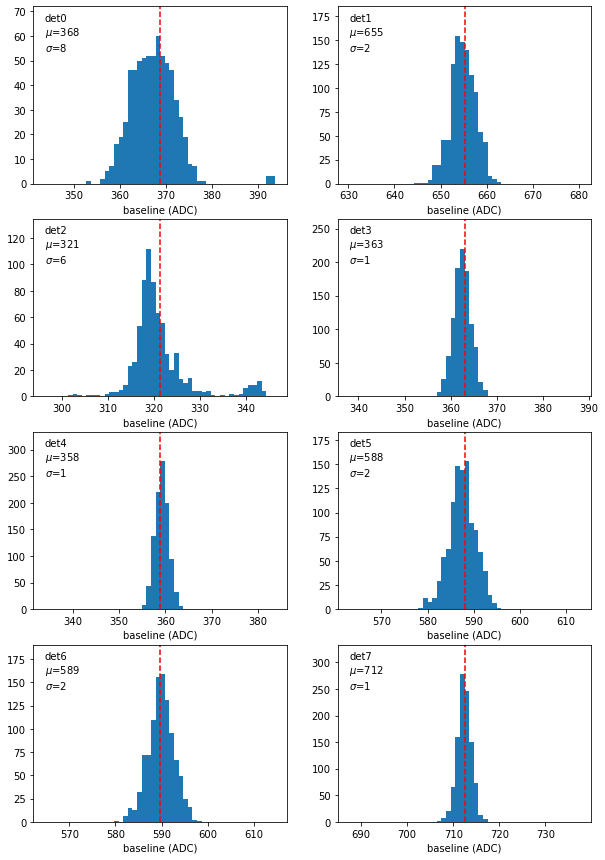

In [9]:
fig = plt.figure(figsize=(10,15))
mean_baseline = np.zeros([N_DETECTOR])
noise = np.zeros([N_DETECTOR])


for idet in range(N_DETECTOR):
    plt.subplot(4, 2, 1+idet)

    bsl = baseline[idet,:][baseline[idet,:]>10]
    mean_baseline[idet] = bsl.mean()
    noise[idet] = np.sqrt(bsl.var())
    val, _, _ = plt.hist(baseline[idet,:][baseline[idet,:]>10],bins=50,range=(mean_baseline[idet]-25,mean_baseline[idet]+25))
    plt.plot([mean_baseline[idet],mean_baseline[idet]],[0,1000],'--',color='red')
    plt.ylim(0,val.max()*1.2)
    plt.xlabel('baseline (ADC)')
    plt.text(mean_baseline[idet]-25,val.max()*0.9,'det'+str(idet)+ '\n$\mu$='+str(int(mean_baseline[idet]))+'\n$\sigma$='+str(int(noise[idet])))

#### Write the baselines to a new config file

In [10]:
#
# read the input json file
#
f = open(config_file,"r")
config = json.load(f)
f.close()

In [11]:
#
# set the BASE variable and fill it with the mean baseline for each detector
#
for idet in range(N_DETECTOR):
    config['detector_settings'][idet]['BASE'] = int(mean_baseline[idet])

In [12]:
with open('config.json',"w") as outfile:
    json.dump(config,outfile,indent=4)